In [2]:
%reset -f
#%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import *
import numpy as np
provider = IBMQ.load_account()

    
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

#constants
n = 4
lambd = 1.2

def thetak(k,lamb):
    num = lamb - np.cos(2*np.pi*k/n)
    denom = np.sqrt( (lamb-np.cos(2*np.pi*k/n))**2 + np.sin(2*np.pi*k/n)**2)
    theta = np.arccos(num/denom)
    return theta

#Create functions based on the decomposition included in appendix of Ising paper
def bog(qcirc, q1, q2, theta):
    qcirc.x(q2)
    qcirc.cx(q2, q1)
    #Controlled RX gate
    qcirc.rz(np.pi/2, q2)
    qcirc.ry(theta/2, q2)
    qcirc.cx(q1, q2)
    qcirc.ry(-theta/2, q2)
    qcirc.cx(q1, q2) #changed from qc to qcirc here - Bruna
    qcirc.rz(-np.pi/2, q2)
    #####################
    qcirc.cx(q2, q1)
    qcirc.x(q2)
    qcirc.barrier()
    return qcirc
    
def fourier(qcirc, q1, q2, phase):
    qcirc.rz(phase, q1)
    qcirc.cx(q1, q2)
    #Controlled Hadamard
    qcirc.sdg(q1)
    qcirc.h(q1)
    qcirc.tdg(q1)
    qcirc.cx(q2, q1)
    qcirc.t(q1)
    qcirc.h(q1)
    qcirc.s(q1)
    ####################
    qcirc.cx(q1, q2)
    qcirc.cz(q1, q2)
    qcirc.barrier()
    return qcirc

def digit_sum(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

def ground_state(lamb, backend_name): # backend is now an imput, so we can plot 
                                      # different ones easily - Bruna
    qc = QuantumCircuit(4, 4)
    #Set correct ground state if lambda < 1
    if lamb < 1:
        qc.x(3)
        qc.barrier()
    #magnetization
    mag = []
    
    #Apply disentangling gates
    qc = bog(qc, 0, 1, thetak(1.,lamb))
    qc = fourier(qc, 0, 1, 2*np.pi/n)
    qc = fourier(qc, 2, 3, 0.)
    qc = fourier(qc, 0, 1, 0.)
    qc = fourier(qc, 2, 3, 0.)
    #Set measurement step
    for i in range(0,4):
        qc.measure(i,i)
        
    backend = Aer.get_backend(backend_name)
    shots = 1024
    max_credits = 10 #Max number of credits to spend on execution
    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qc)
    ##while not '0000' in counts:
    #    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    #    job_monitor(job)
    #    result = job.result()
    #    counts = result.get_counts(qc)
    #Check what ground state is based on lambda
    
    r1=list(counts.keys())
    r2=list(counts.values())
    M=0
    for j in range(0,len(r1)):
        M=M+(4-2*digit_sum(r1[j]))*r2[j]/shots
    #print("$\lambda$: ",lam,", $<\sigma_{z}>$: ",M/4)
    mag.append(M/4)
    return mag
    
   # if lamb < 1:
   #     return counts['0001']
   # return counts['0000']/shots # it does not always works, sometimes it returns keyword error 
                                # maybe we can add another else for the possibility of other states, but 
                                # do not use it for plotting - Bruna


print(ground_state(lambd, 'qasm_simulator'))

#print(ground_state(.8,'statevector_simulator'))

C:\Users\mattm\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Job Status: job has successfully run
[0.876953125]


In [4]:
lmbd = np.arange(.2, 1.75, 0.1)
sigmaz = []
for l in lmbd:
    sigmaz.append(ground_state(l, 'qasm_simulator'))
    
print(sigmaz)



Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[[0.083984375], [0.15234375], [0.17578125], [0.251953125], [0.25390625], [0.2841796875], [0.32421875], [0.3291015625], [0.845703125], [0.8759765625], [0.892578125], [0.8896484375], [0.8974609375], [0.9267578125], [0.9228515625], [0.931640625]]


(0.0, 1.8)

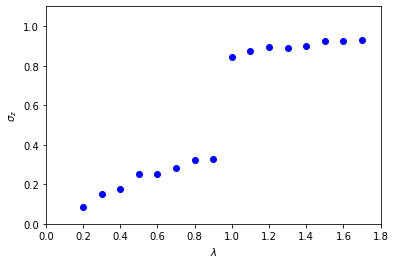

In [9]:

plt.plot(lmbd, sigmaz,'bo')
plt.ylabel("$\sigma_z$")
plt.xlabel("$\lambda$")
plt.ylim(0., 1.1)
plt.xlim(0., 1.8)

$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$ \newcommand{\bra}[1]{\left\langle{#1}\right|}$
$$ \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

The following code initializes the state to $ \ket{0000}  $ and $\ket{ 1100} $. It then applies the disentangling gates specified above using the backend of choice. The counts are plotted as a histogram.

Job Status: job has successfully run


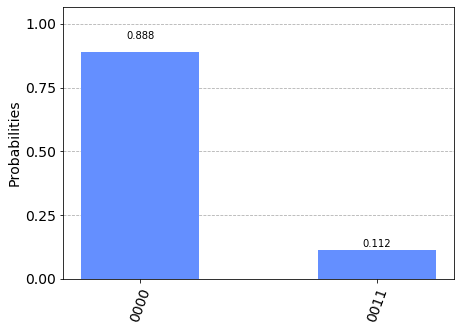

In [7]:
#Start up and initialize circuit
#Measurement
qc = QuantumCircuit(4, 4)
    #Set correct ground state if lambda < 1
if lambd < 1:
    qc.x(3)
    qc.barrier()

    #Apply disentangling gates
qc = bog(qc, 0, 1, thetak(1.,1.2))
qc = fourier(qc, 0, 1, 2*np.pi/n)
qc = fourier(qc, 2, 3, 0.)
qc = fourier(qc, 0, 1, 0.)
qc = fourier(qc, 2, 3, 0.)
    #Set measurement step
for i in range(0,4):
    qc.measure(i,i)
    

    
    #Choose provider and backend
#provider = IBMQ.get_provider()
#provider = AerProvider()
#backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = provider.get_backend('ibmqx4')
#backend = provider.get_backend('ibmqx2')
#backend = provider.get_backend('ibmq_16_melbourne')

shots = 1024
max_credits = 10 #Max number of credits to spend on execution
job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)  
job_monitor(job)
result = job.result()
counts = result.get_counts(qc)
#print(counts['0000'])
plot_histogram(counts)

# had to comment this part because qc is a local variable in groundstate function now - Bruna

In [8]:
phi = np.arccos(lambd/np.sqrt(1+lambd**2))/2
#print(result.get_statevector(qc))
print("|0000> probability should be: ",np.cos(phi)**2)
print("|0011> probability should be: ",np.sin(phi)**2 )

|0000> probability should be:  0.8841106397986879
|0011> probability should be:  0.11588936020131207


In [9]:
#print(counts['0000'])

# lets try the time evolution

$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

Steps (as listed in the tutorial):

 - 1) choose an initial state in computational basis
 - 2) apply time evolution operator $e^{-H_{comp}}t$ to the initial state. 

\begin{equation} e^{-H_{comp}t} \ket{\Psi(t)} = e^{2it(\lambda + \sqrt{1 +\lambda^2})} \big ( \cos{\phi} \ket{00} + ie^{4it\sqrt{1 + \lambda^2}}\sin{phi} \ket{11} \big ) \otimes \ket{00}
\end{equation}

to do this we use a U3 gate defined as 

\begin{equation} U3(a, b, c) = \begin{bmatrix}  \cos{a} & e^{-ic}\sin{a \over 2} \\ e^{-ib}\sin{a \over 2} & e^{i(b+c)}\cos{a \over 2} \end{bmatrix}\end{equation}


overall phase is arbitrary 

$$ a = \phi = {\cos({\lambda \over \sqrt{1 +\lambda^2}})^{-1} \over 2}  $$
and 
$ b = {\pi \over 2} + 4t\sqrt{1 +\lambda^2} $ for some reason and finally
$c = 0$

  - 3) apply disentangle gate. a.k.a apply our ground_state function to see what the ground state is at some time t>0
  - 4) then plot for multiple times

In [12]:


def Time_Evo(t, lamb, backend_name):
    quc = QuantumCircuit(4, 4)
    
    #step 1. we are already in the |111> state
        
    # time evolution of computational basis, step 2
    quc.u3(np.arccos(lamb/np.sqrt(1+lamb**2)), np.pi/2 + 4*t*np.sqrt(1+lamb**2),0,0)
    quc.cx(0,1)
    

    #magnetization
    mag = []
    #step 3
    #Apply disentangling gates
    quc = bog(quc, 0, 1, thetak(1.,lamb))
    quc = fourier(quc, 0, 1, 2*np.pi/n)
    quc = fourier(quc, 2, 3, 0.)
    quc = fourier(quc, 0, 1, 0.)
    quc = fourier(quc, 2, 3, 0.)
    #Set measurement step
    for i in range(0,4):
        quc.measure(i,i)
        
    
    #provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backend = provider.get_backend(backend_name)
    #backend = Aer.get_backend('statevector_simulator')
    #backend = Aer.get_backend('qasm_simulator')
    #backend = provider.get_backend('ibmq_qasm_simulator')
    #backend = provider.get_backend('ibmqx4')
    #backend = provider.get_backend('ibmqx2')
    #backend = provider.get_backend('ibmq_16_melbourne')
    shots = 1024
    max_credits = 10 #Max number of credits to spend on execution
    job = execute(quc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(quc)
    ##while not '0000' in counts:
    #    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    #    job_monitor(job)
    #    result = job.result()
    #    counts = result.get_counts(qc)
    #Check what ground state is based on lambda
    
    r1=list(counts.keys())
    r2=list(counts.values())
    M=0
    for j in range(0,len(r1)):
        M=M+(4-2*digit_sum(r1[j]))*r2[j]/shots
    #print("$\lambda$: ",lam,", $<\sigma_{z}>$: ",M/4)
    mag.append(M/4)
    return mag

#f = Time_Evo(qc,1,lambd,'qasm_simulator')
#print(f)

#
ti = 0
tf = 2
time = np.arange(ti,tf,(tf-ti)/10)
f = []
for t in time:
    f.append(Time_Evo(t,0.5,'ibmq_athens'))
    

C:\Users\mattm\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  import sys


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [11]:
#step 4
plt.plot(time, f)
plt.ylim(0., 1)
plt.xlim(0., 1.8)
plt.ylabel("Magnetization")
plt.xlabel("t")
plt.show()

NameError: name 'time' is not defined